Kesinlikle; kodu **zaman çizelgesi + adet + şekiller (shape)** üzerinden, net ve sayılarla anlatalım.
(Aşağıdaki sayılar, bu popüler örnekteki gibi **train=1258 gün**, **test=20 gün**, **lookback=60** varsayımıyla anlatılıyor.)

---

# 1) Eğitim verisini hazırlama (rolling window)

```python
dataset_train = pd.read_csv("Google_Stock_Price_Train.csv")
training_set = dataset_train.iloc[:,1:2].values   # 'Open' sütunu -> (1258, 1)
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
```

* **Fit** sadece train’de yapılıyor (sızıntı yok).
* Ölçeklenmiş şekil: `(1258, 1)`.

```python
X_train, y_train = [], []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])  # 60 gün geçmiş
    y_train.append(training_set_scaled[i, 0])       # ertesi gün (hedef)
```

* `i` **60…1257** → toplam **1258-60 = 1198** örnek (sample).
* Her `X_train` örneği: **60 günlük** dilim → şekli `(60,)`.
* Her `y_train` örneği: **tek değer** (o dilimi izleyen **1 gün**).

```python
X_train = np.array(X_train)           # (1198, 60)
y_train = np.array(y_train)           # (1198,)
X_train = X_train.reshape(1198, 60, 1)
```

* Son şekiller:

  * **X\_train:** `(1198, 60, 1)`  → 1198 adet örnek, her örnek 60 adım × 1 özellik
  * **y\_train:** `(1198,)`         → 1198 hedef

> Yani eğitim tam olarak **many-to-one**: “**60 gün → 1 gün**”.

---

# 2) Model mimarisi ve ara çıktılar (sezgisel şekiller)

```python
regressor = Sequential()
regressor.add(LSTM(50, return_sequences=True, input_shape=(60,1)))  # → (batch, 60, 50)
regressor.add(Dropout(0.2))

regressor.add(LSTM(50, return_sequences=True))                      # → (batch, 60, 50)
regressor.add(Dropout(0.2))

regressor.add(LSTM(50, return_sequences=True))                      # → (batch, 60, 50)
regressor.add(Dropout(0.2))

regressor.add(LSTM(50))                                             # → (batch, 50)
regressor.add(Dropout(0.2))

regressor.add(Dense(1))                                             # → (batch, 1)
```

* İlk 3 LSTM `return_sequences=True` → her zaman adımı için dizi (sequence) döndürür.
* Son LSTM **sequence’i özetler** → tek vektör (50).
* **Dense(1)** → **yarın (tek sayı)**.

Eğitim:

```python
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=32)
```

* **Batch size 32** → her epoch’ta yaklaşık `ceil(1198/32)=38` güncelleme adımı.

---

# 3) Test verisini hazırlama (kayan pencere – günlük tahmin)

```python
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:,1:2].values   # (20, 1) — 2017 Ocak tipik örnek

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)  # 1258 + 20 = 1278
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values       # son (60 + 20) = 80 gün
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)   # aynı scaler ile ölçekle (yalnızca transform!)
```

* `inputs` uzunluğu **80**: **son 60 train günü + 20 test günü** (ölçekli).

```python
X_test = []
for i in range(60, 80):   # 60..79  → 20 pencere
    X_test.append(inputs[i-60:i, 0])  # her seferinde 60 gün
X_test = np.array(X_test).reshape(20, 60, 1)
```

* **X\_test:** `(20, 60, 1)` → **20 günlük** test döneminin **her günü** için **60 günlük** geçmiş veriliyor.

  * i=60 → `inputs[0:60]` = **son 60 train günü** → **test’in 1. günü** tahmini
  * i=61 → `inputs[1:61]` = 59 train + **1 test** günü → **test’in 2. günü** tahmini
  * … böyle **kayan pencere** ile günlük tahmin.

Tahmin ve ters ölçekleme:

```python
predicted_stock_price = regressor.predict(X_test)          # (20, 1) — günlük tahminler
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
```

* Artık **gerçek** (`real_stock_price`) ve **tahmin** (`predicted_stock_price`) **aynı ölçekte** (orijinal fiyat).

Grafik:

```python
plt.plot(real_stock_price, color='red',  label='Real')
plt.plot(predicted_stock_price, color='blue', label='Predicted')
```

* Üst üste **günlük** (20 nokta) çizilir. **“60’ar günlük aralık” yok;**
  60 gün **bağlam** (girdi), **tahminler günlük** üretiliyor.

---

## Kafanda böyle tut:

* **Eğitim:**
  Her örnek = **\[t-59 … t] → hedef t+1** → **1198** örnek, `X:(1198,60,1)`, `y:(1198,)`
* **Test:**
  **20** gün için her seferinde **60 gün geriye** bak → `X_test:(20,60,1)` → **20** tahmin
* **Model:**
  4 katman LSTM (50 ünite), sonu Dense(1) → **many-to-one** (60→1)

---

### Küçük sağlamlaştırma (sabit 80 yazma)

Test boyutuna duyarlı yazmak daha doğru:

```python
for i in range(60, 60 + len(dataset_test)):
    X_test.append(inputs[i-60:i, 0])
```

İstersen, bu kodu **şekilleri (shape) ve adetleri konsola basacak** minik `print()` satırlarıyla birlikte yeniden düzenleyeyim; adım adım çıktıları görerek ilerlersin.



[TRAIN] Orijinal eğitim seti şekli: (1258, 1)
[TRAIN] İlk 5 değer (Open): [325.25 331.27 329.83 328.34 322.04]

[TRAIN] Ölçeklenmiş eğitim seti şekli: (1258, 1)
[TRAIN] Ölçekli ilk 5 değer: [0.08581368 0.09701243 0.09433366 0.09156187 0.07984225]
[TRAIN] Ölçekli min-max (train): 0.0 1.0

[TRAIN] Üretilen örnek sayısı: 1198
[TRAIN] X_train şekli: (1198, 60, 1)  (samples, timesteps, features)
[TRAIN] y_train şekli: (1198,)  (samples,)
[TRAIN] Örnek 0: inputs indices [0..59] -> target index 60
[TRAIN] Örnek 1: inputs indices [1..60] -> target index 61
[TRAIN] Örnek 2: inputs indices [2..61] -> target index 62

[MODEL] Many-to-one mimari: 60 gün -> 1 gün (Dense(1))
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)  

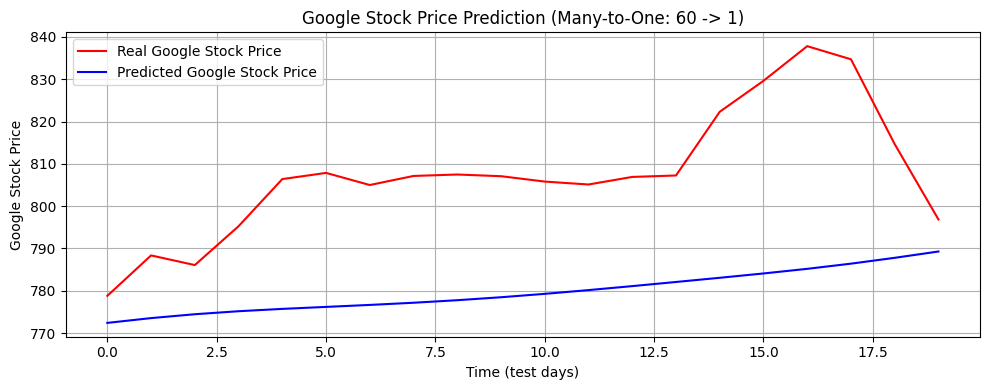

In [1]:
# lstm_google_stock_step_by_step.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# Keras / TensorFlow
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --------------------
# 0) Parametreler
# --------------------
LOOKBACK = 60      # geçmiş gün sayısı (pencere uzunluğu)
EPOCHS   = 10      # eğitim epoch (demoda düşük)
BATCH    = 32

np.random.seed(42)

# --------------------
# 1) Eğitim verisini oku
# --------------------
dataset_train = pd.read_csv("Google_Stock_Price_Train.csv")
# 'Open' sütunu 2. sütun (index=1) olarak varsayılıyor
training_set = dataset_train.iloc[:, 1:2].values  # shape: (N_train, 1)

print("\n[TRAIN] Orijinal eğitim seti şekli:", training_set.shape)
print("[TRAIN] İlk 5 değer (Open):", training_set[:5, 0])

# --------------------
# 2) Ölçekleme (yalnızca train ile fit!)
# --------------------
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

print("\n[TRAIN] Ölçeklenmiş eğitim seti şekli:", training_set_scaled.shape)
print("[TRAIN] Ölçekli ilk 5 değer:", training_set_scaled[:5, 0])
print("[TRAIN] Ölçekli min-max (train):", float(training_set_scaled.min()), float(training_set_scaled.max()))

# --------------------
# 3) Rolling window: X_train, y_train oluştur
#    X[i] = [t-59 ... t]  (60 zaman adımı)
#    y[i] = t+1           (bir sonraki gün)
# --------------------
X_train, y_train = [], []
n_train = training_set_scaled.shape[0]

for i in range(LOOKBACK, n_train):
    X_train.append(training_set_scaled[i-LOOKBACK:i, 0])  # (60,)
    y_train.append(training_set_scaled[i, 0])             # (1,)

X_train = np.array(X_train)                                # (N_samples, 60)
y_train = np.array(y_train)                                # (N_samples,)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # (N_samples, 60, 1)

print("\n[TRAIN] Üretilen örnek sayısı:", X_train.shape[0])
print("[TRAIN] X_train şekli:", X_train.shape, " (samples, timesteps, features)")
print("[TRAIN] y_train şekli:", y_train.shape, " (samples,)")

# Örnek indeks eşlemesi (ilk 3 örnek)
for k in range(3):
    start = k
    end   = k + LOOKBACK - 1
    target = k + LOOKBACK
    print(f"[TRAIN] Örnek {k}: inputs indices [{start}..{end}] -> target index {target}")

# --------------------
# 4) Model: many-to-one (60 -> 1)
# --------------------
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(LOOKBACK, 1)))  # (batch, 60, 50)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))  # (batch, 60, 50)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))  # (batch, 60, 50)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))                         # (batch, 50)
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))                         # (batch, 1) -> yarın

regressor.compile(optimizer='adam', loss='mean_squared_error')
print("\n[MODEL] Many-to-one mimari: 60 gün -> 1 gün (Dense(1))")
regressor.summary()

# --------------------
# 5) Eğitim
# --------------------
print("\n[TRAIN] Eğitim başlıyor...")
history = regressor.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=1)

# --------------------
# 6) Test verisini hazırla (sızıntısız)
# --------------------
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values   # shape: (N_test, 1)
n_test = real_stock_price.shape[0]

print("\n[TEST] Gerçek test gün sayısı:", n_test)
print("[TEST] İlk 5 gerçek test değeri:", real_stock_price[:5, 0])

# Train + Test'i birleştir, testten hemen önceki 60 günü de kapsayacak şekilde inputs hazırla
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)  # uzunluk: n_train + n_test
start_idx = len(dataset_total) - n_test - LOOKBACK
end_idx   = len(dataset_total) - 1
inputs = dataset_total[start_idx:].values.reshape(-1, 1)  # son (LOOKBACK + n_test) gün
inputs_scaled = sc.transform(inputs)

print(f"\n[TEST] dataset_total uzunluğu: {len(dataset_total)}")
print(f"[TEST] inputs aralığı: dataset_total[{start_idx} .. {end_idx}] (uzunluk = {inputs.shape[0]})")
print("[TEST] inputs_scaled min-max:", float(inputs_scaled.min()), float(inputs_scaled.max()))

# Kayan pencere ile her test günü için 60 günlük geçmiş oluştur
X_test = []
for i in range(LOOKBACK, LOOKBACK + n_test):  # örn: 60..60+19
    # DİKKAT: inputs_scaled içinde indeksler 0'dan başlıyor
    window = inputs_scaled[i-LOOKBACK:i, 0]   # (60,)
    X_test.append(window)

X_test = np.array(X_test).reshape(n_test, LOOKBACK, 1)
print("\n[TEST] X_test şekli:", X_test.shape, "(samples=test gün sayısı, timesteps=60, features=1)")

# Örnek indeks eşlemesi (ilk 3 test örneği)
for k in range(min(3, n_test)):
    # inputs_scaled içindeki eşlem
    in_start = k
    in_end   = k + LOOKBACK - 1
    print(f"[TEST] Örnek {k}: inputs_scaled indices [{in_start}..{in_end}] -> tahmin {k}. test günü")

# --------------------
# 7) Tahmin ve inverse transform
# --------------------
pred_scaled = regressor.predict(X_test)          # (n_test, 1)
predicted_stock_price = sc.inverse_transform(pred_scaled)  # (n_test, 1)

print("\n[RESULT] predicted_stock_price şekli:", predicted_stock_price.shape)
print("[RESULT] real_stock_price şekli:", real_stock_price.shape)
print("[RESULT] İlk 5 tahmin vs gerçek:")
for i in range(min(5, n_test)):
    print(f"  Day {i:02d} -> Pred: {predicted_stock_price[i,0]:.4f} | Real: {real_stock_price[i,0]:.4f}")

# --------------------
# 8) Grafik
# --------------------
plt.figure(figsize=(10,4))
plt.plot(real_stock_price,  color='red',  label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction (Many-to-One: 60 -> 1)')
plt.xlabel('Time (test days)')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()